## Case of 8 sources and 50 receptors, with left boundary of Dirichlet type.

In [ ]:
from dolfin import *
from mshr import * 
import numpy as np
#%matplotlib inline

# Rectangle geometry limits
zlim, ylim = 70., 1.
# Porosity level from Mathilde data 
# this data starts from 1% porosity values!
por = 11 # the porosity level is por+1
# Define domain size 
size = 350
# generate f and create mesh
domain = Rectangle(Point(0., 0.), Point(zlim, ylim))
mesh = generate_mesh(domain, size)
# Compute the minimum height diameter
print("Minimum height of element [mm]: ", mesh.hmin())
#File("Domains/2DMesh.pvd") << mesh

# Define source locations
# Using notation consistent with the 3D-case
nsous = 8
zsous, ysous = [n for n in range(10, 25, 2)], nsous*[ylim,]
eps = DOLFIN_EPS
width = 0.5

# Define domain for each source
class DomSource_1(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[0]) < width + eps and
                abs(x[1] - ysous[0]) < width + eps and
                on_boundary)

class DomSource_2(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[1]) < width + eps and
                abs(x[1] - ysous[1]) < width + eps and
                on_boundary)    

class DomSource_3(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[2]) < width + eps and
                abs(x[1] - ysous[2]) < width + eps and
                on_boundary)    

class DomSource_4(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[3]) < width + eps and
                abs(x[1] - ysous[3]) < width + eps and
                on_boundary)    

class DomSource_5(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[4]) < width + eps and
                abs(x[1] - ysous[4]) < width + eps and
                on_boundary)
    
class DomSource_6(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[5]) < width + eps and
                abs(x[1] - ysous[5]) < width + eps and
                on_boundary)
    
class DomSource_7(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[6]) < width + eps and
                abs(x[1] - ysous[6]) < width + eps and
                on_boundary)
    
class DomSource_8(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[7]) < width + eps and
                abs(x[1] - ysous[7]) < width + eps and
                on_boundary)

# Define source expression
class Source(Expression):
    def __init__(self, time, t_0,
                 sig_time, degree=1):
        # initialize atributes
        self.time, self.t_0 = time, t_0
        self.sig_time = sig_time
    
    def eval(self, values, x):
        factor = 1/(2*pow(self.sig_time,2))
        dif_time = self.time - self.t_0
        # Obtaining left side and right sides
        num = exp(-factor*pow(dif_time,2))*cos(2*pi*dif_time)
        # Define values for the vector
        values[0] = 0.0 # the horizontal direction
        values[1] = -num # vertical direction
        # DEBUG CASE!
        #values[1] = -cos(2*pi*dif_time)

    def value_shape(self):
        return (2,)
    
"""
from IPython.display import HTML
HTML(X3DOM().html(mesh))
"""
print("Number of Cells; {0}, of Vertice: {1}".format(mesh.num_cells(),
                                                  mesh.num_vertices()))

# Define update procedure
def update(u, u_n, v_n, a_n, beta, gamma, dt):
    """
    Update procedure for the acceleration using the
    beta-Newmark scheme.
    """
    # Obtain vector representation of fields
    u_vec, u_nvec = u.vector(), u_n.vector()
    v_nvec, a_nvec = v_n.vector(), a_n.vector()
    # update using the beta-gamma scheme
    a_vec = (1.0/(beta*pow(dt,2)))*(u_vec-u_nvec-dt*v_nvec) - \
            ((1-2*beta)/(2*beta))*a_nvec
    # update velocity
    v_vec = v_nvec + dt*((1-gamma)*a_nvec+gamma*a_vec)
    # update fields 
    v_n.vector()[:], a_n.vector()[:] = v_vec, a_vec
    u_n.vector()[:] = u.vector()

In [ ]:
# Position of sensor to obtain the dforce!
nsens = 50# Number of sensors separated at 0.4081 mm
zsens, ysens = np.linspace(35, 55, num=nsens), nsens*[ylim,]

# Define function spaces and boundary conditions
pdim = 1
V = VectorFunctionSpace(mesh, 'CG', pdim)
# Define trial and test functions
u = TrialFunction(V)
w = TestFunction(V)

# Mark subdomains with label 0
#subdomains = MeshFunction("size_t", mesh, mesh.topology().dim())
#subdomains.set_all(0)
# Mark boundaries with label 0
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)

# Mark boundaries (whenever necessary)
# Mark domain sources with 2
DomSource_1().mark(boundaries, 21)
DomSource_2().mark(boundaries, 22)
DomSource_3().mark(boundaries, 23)
DomSource_4().mark(boundaries, 24)
DomSource_5().mark(boundaries, 25)
DomSource_6().mark(boundaries, 26)
DomSource_7().mark(boundaries, 27)
DomSource_8().mark(boundaries, 28)

# Define new measure for boundaries
dx = dx(domain=mesh)
ds = ds(domain=mesh, subdomain_data=boundaries)

# Define boundaries over the function space
# In the variational form are defined the Neumann conditions
left_jit = "on_boundary && near(x[0], 0.)"
bc_domain = DirichletBC(V, Constant((0.,0.)), left_jit)

In [ ]:
# Obtain the experimental data from .mat file
import scipy.io as sio
import numpy as np
C_mathilde = sio.loadmat('Files_mat/C_values_mathilde.mat')
# Define the constants
# The stiffness constants in [GPa] --> [g/mm(\mu sec)^2]
# are given by the mathilde .mat file of 5%
C11 = np.reshape(C_mathilde['C11'], (30,))*1E-3
C12 = np.reshape(C_mathilde['C12'], (30,))*1E-3
C13 = np.reshape(C_mathilde['C13'], (30,))*1E-3
C33 = np.reshape(C_mathilde['C33'], (30,))*1E-3
C55 = np.reshape(C_mathilde['C55'], (30,))*1E-3
C66 = np.reshape(C_mathilde['C66'], (30,))*1E-3
d = np.reshape(C_mathilde['d'], (30,))*1E-3
C_mathilde.keys()

In [ ]:
por = 5 # 6% of porosity
print(""" At {0}% of porosity, density of {1:2.4f},
C11 = {2:2.4f}, C33 = {3:2.4f}, C55 = {4:2.4f}
C66 = {5:2.4f}, C12 = {6:2.4f}, C13 = {7:2.4f}
""".format(por+1, d[por], 
           C11[por], C33[por], C55[por], 
           C12[por], C13[por], C66[por]))

In [ ]:
# Comparison of values
print("""
      At porosity of {0}%; The coeffs:
      C22: {1:.4f}, C33: {2:.4f}
      density d: {3:.6f}
      """.format(por+1,C11[por],C33[por],d[por]))

In [ ]:
# Define kronecker delta in 2D and indices
delta = Identity(2)
i,j,k,l = indices(4)

# Define strain tensor
def epsilon(u): 
    return as_tensor(0.5*(u[i].dx(j)+u[j].dx(i)),
                    (i,j))

# Define stiffness tensor C_{i,j,k,l} transverse isotropic
def VoigtToTensor(A):
    # We use the convention, for long axis 1
    # Upper diagonal part
    A11, A13, A15 = A[0,0], A[0,1], A[0,2]
    A33, A35 = A[1,1], A[1,2]
    A55 = A[2,2]
    # Lower diagonal part (symmetric)
    A31, A51 = A13, A15
    A53 = A35
    
    return as_tensor([\
           [\
            [ [A11, A15], [A15, A13]] ,\
            [ [A51, A55], [A55, A53]] \
           ], \
           [
            [ [A51, A55], [A55, A53]] ,\
            [ [A31, A35], [A35, A33]] \
           ] \
                     ])

# We take the standard density
rho = d[por] # [g/cm^3] --> [g/(mm)^3]
# Define the Voigt matrix representing the tensor
# Here, the 3-axis is the z-axis, and
# 1-axis in the y-axis or x-axis by the simmetry
C_voigt = np.array([\
                   [C33[por], C13[por], 0], \
                   [C13[por], C11[por], 0], \
                   [0, 0, C55[por]] 
                   ])
# Obtain the stiffness tensor
C = VoigtToTensor(C_voigt)
# Define stress tensor
def sigma(u):
    return as_tensor(C[i,j,k,l]*epsilon(u)[k,l], 
                     (i,j))

In [ ]:
# Define the three main blocks in variational forms
def o_block(u, w, dt):
    # Define factor por derivative variational form
    factor_1 = rho/(beta*dt*dt)
    return factor_1*inner(u, w)*dx

def A_block(u, w):
    return inner(sigma(u), grad(w))*dx

def b_block(u, u_n, v_n, a_n, w, beta, gamma, dt):
    # Define useful factors
    factor_1 = rho/(beta*dt*dt)
    factor_2 = rho/(beta*dt)
    factor_3 = rho*(1.0-2.0*beta)/(2.0*beta)
    # rhs without force defined from time-derivative rest
    value_wtf = factor_1*inner(u_n, w)*dx + \
                factor_2*inner(v_n, w)*dx + \
                factor_3*inner(a_n, w)*dx
    # return the sum of value_wtf
    return value_wtf

def bdry_block(source, w, bdry_id):
    # rhs part containing the force applied at the boundary
    return dot(source, w)*ds(bdry_id)

# Time array to consider
# samplign step 1/20, ntimes = 1024
times = np.arange(0, 51.2, step = 1./20)# experiment ~ 48[\mu sec]
# Define number of times from array
ntimes = times.shape[0]
# Define sensors arrays
sol_sensors_z = np.zeros((nsens, ntimes, nsous))
sol_sensors_y = np.zeros((nsens, ntimes, nsous))

d = u.geometric_dimension()
u_shape = grad(u).ufl_shape
print("Geometric dimension of u: {0}".format(d))
print("UFL shape of grad(u): {0}".format(u_shape))
"""
# Check the points where the force is applied
mesh_points = SubsetIterator(boundaries, 21)
print("Midpoints where the force is applied")

for data in mesh_points:
    print("Points at boundary 21, ({0},{1}) ".format(
        data.midpoint().x(), data.midpoint().y()))
            
"""
for ii in range(nsous):
    idx = int(ii + 21)
    count = sum(1 for _ in SubsetIterator(boundaries,idx))
    print("Facet marked as %d have %d points" % (idx, count))

In [ ]:
# Check if the points a the left have been taken.
print("Points at boundary left: ")
len(bc_domain.get_boundary_values())

In [ ]:
# list all boundaries
bcs = [bc_domain]
# Define name solutions for saving with File
filename = "SimP"+str(por+1)+"TransIso"+str(ylim)+ \
           "M"+str(size)+".pvd"
filepvd ="Results/"+filename
vtk_u = File(filepvd)
# Define file to save data at experiment with sous 2
#filename_sol = "SimSous6P"+str(por+1)+"TransIso"+str(ylim)+ \
#               "M"+str(size)+".pvd"
#filepvd_sol ="Results/"+filename_sol
#vtk_u_sol = File(filepvd_sol)
# Parameters for the Newmark scheme
beta, gamma = 0.36, 0.7
    
# output the dt time
dt = times[1]-times[0]
print("Considering dt: ", dt)
# Iteration over each source secuentially
for sous_j in range(nsous):
    # Obtain boundary layer and assemble it!
    bdry_id = int(21 + sous_j)
    # Create functions for variational form definition
    # initialized all as 0.0
    u_sol = Function(V)
    # previous time solutions
    u_n, v_n, a_n = Function(V), Function(V), Function(V)
    
    # Iterate the experiment over time
    for time_i in range(ntimes):
        ## Define Neumann boundary condition for source 
        time, t_0 = float(times[time_i]), 0.0#5.0#t_0 ~ 5 [\mu sec]
        # Define general variance
        sig_time = 0.7 # sig_time ~ 1 [\mu sec]
        source_exp = Source(time=time, t_0=t_0,
                            sig_time=sig_time, degree=1)
        # Interpolate source over domain
        source = interpolate(source_exp, V)

        # Variational forms for A and assemble!
        A_lhs = o_block(u, w, dt) + A_block(u, w)
        A = assemble(A_lhs)
        
        # Obtain variational part without force
        b_wtf = b_block(u, u_n, v_n, a_n, w, beta, gamma, dt)
        # Obtain variational part of rhs with force at the boundary
        b_wf = bdry_block(source, w, bdry_id)
        b_rhs = b_wtf + b_wf
        # Assemble of lhs
        b = assemble(b_rhs)
        
        # Apply boundary conditions
        [bc.apply(A,b) for bc in bcs]
        
        # Solve the variational problem
        solve(A, u_sol.vector(), b)
            
        # Update fields u, v, a
        update(u_sol, u_n, v_n, a_n, beta, gamma, dt)
        
        # Compute data at the sensors and save it as array
        for sens_k in range(nsens):
            # Obtain point value of solution u
            sensor_point = Point(np.array((zsens[sens_k], ysens[sens_k])))
            # Save data values at the sensor location
            sol_sensors_z[sens_k, time_i, sous_j] = u_sol(sensor_point)[0]
            sol_sensors_y[sens_k, time_i, sous_j] = u_sol(sensor_point)[1]
                
        if sous_j == 0:
            # Save vtk solution
            #vtk_u << (u_sol, float(time_i)) 
            # Print some info in the iteration
            print("Value at sensor: {0}, with Time: {1} ".format(
                  u_sol(sensor_point)[1], time))
        #if sous_j == 5:
        #    vtk_u_sol << (u_sol, float(time_i))

In [ ]:
import scipy.io as sio
# create dictionary with variables to save
savedic = {'zlim': zlim, 'ylim': ylim, 'nsous': nsous,
          'zsous': zsous, 'ysous': ysous, 'nsens': nsens,
          'zsens': zsens, 'ysens': ysens, 'ntimes': ntimes,
          'times': times,
          'sol_sensors_z': sol_sensors_z, 'sol_sensors_y': sol_sensors_y}
filename = 'Files_mat/TimeSimP'+str(por+1)+'TransIsoW'+ \
           str(ylim)+'M'+str(size)
sio.savemat(filename, savedic, appendmat=True)

## Data Processing and diagram plotting

In [1]:
# Cell created just for testing and recovering purposes
import scipy.io as sio
from scipy.signal import hilbert
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# First, import data!
data = sio.loadmat('Files_mat/TimeSimP3TransIsoW2.8M780.mat')
size = 780
por = 2 # Porosity = por + 1
zlim, ylim = float(data['zlim']), float(data['ylim'])
nsous, nsens = int(data['nsous']), int(data['nsens'])
zsous, ysous = np.reshape(data['zsous'], (nsous,)), np.reshape(data['ysous'], (nsous,))
zsens, ysens = np.reshape(data['zsens'], (nsens,)), np.reshape(data['ysens'], (nsens,))

ntimes = int(data['ntimes'])
times = np.reshape(data['times'], (ntimes,))
sol_sensors_z = data['sol_sensors_z']
sol_sensors_y = data['sol_sensors_y']

data.keys()

dict_keys(['zsous', 'ysens', 'sol_sensors_y', 'ylim', 'ntimes', 'ysous', '__globals__', 'nsens', 'zlim', '__version__', 'times', '__header__', 'zsens', 'nsous', 'sol_sensors_z'])

In [2]:
# Variables: (Number of receptors, N. times, N. of emitters)
sol_sensors_y.shape

(50, 1024, 8)

In [3]:
def NormSVB(f_id, k, iFU, M):
    
    norm_fk = float(0) # to save to norm value
    
    # Iterate over the first M columns of U
    for m in range(M):
        norm_fk += np.absolute(iFU[k, f_id, m])
    return norm_fk

def dB_signal(sous_id, signal):
    """
    The input signal has dim: (nsous,nfreq)
    """
    return 20*np.log10(signal[sous_id, :])

In [4]:
## Take just sensors separated at 0.4081 [mm]
from scipy.signal import hilbert
# Sizes of sol_signal \in N_R \times N_times \times N_E
# Tranform to frequency domain the time-domain signal}
# with 205 frequencies
F_sol_sensors_z = np.fft.fft(sol_sensors_z, n = ntimes,
                             axis=1, norm='ortho')
F_sol_sensors_y = np.fft.fft(sol_sensors_y, n = ntimes,
                             axis=1, norm='ortho')

freqs = np.fft.fftfreq(n = ntimes, d = times[1]-times[0])[:205]

# Define the number of freqs
nfreqs = 205
# Amount of wavenumber to consider
nwavenums = 2*256

# Cut to the first 205 frequencies
F_sol_sensors_z = F_sol_sensors_z[:,0:nfreqs,:]
F_sol_sensors_y = F_sol_sensors_y[:,0:nfreqs,:]
# Create 3d array to store svd for each freq
# and iFU : the inverse fourier transform
U_z = np.zeros((nsens, nfreqs, nsens), dtype=complex)
U_y = np.zeros((nsens, nfreqs, nsens), dtype=complex)
iFU_z = np.zeros((nwavenums, nfreqs, 15), dtype=complex)
iFU_y = np.zeros((nwavenums, nfreqs, 15), dtype=complex)

sig_y = np.zeros((nsous, nfreqs), dtype=float)

# Iterate now over the frequencies
for freq in range(nfreqs):
    # Decomposition using SVB
    U_z[:,freq,:], sig, V = np.linalg.svd(F_sol_sensors_z[:,freq,:], full_matrices=True)
    U_y[:,freq,:], sig_y[:,freq], V = np.linalg.svd(F_sol_sensors_y[:,freq,:], full_matrices=True)
    # Compute space fourier transform, using first axis
    iFU_z[:,freq,:] = np.fft.fft(U_z[:,freq,0:15], 
                                  n=nwavenums, axis=0, norm='ortho') 
    iFU_y[:,freq,:] = np.fft.fft(U_y[:,freq,0:15], 
                                  n=nwavenums, axis=0, norm='ortho')

# Consider only the first M principal signals
M = [1, 2, 4, 6]
    
# Define matrix of solutions
matrix_fk_z = np.zeros((nfreqs, nwavenums, len(M)))
matrix_fk_y = np.zeros((nfreqs, nwavenums, len(M)))

# Obtain norm for each frequency and wavenumber
for f_id, wv_id, M_id in np.ndindex(matrix_fk_z.shape):
    matrix_fk_z[f_id, wv_id, M_id] = NormSVB(f_id, wv_id, iFU_z, M[M_id])
    matrix_fk_y[f_id, wv_id, M_id] = NormSVB(f_id, wv_id, iFU_y, M[M_id])
    if f_id == 10 and wv_id == 5:
        print("Computing for freq_id: {0:.2f}".format(
              f_id))
        print(" Value of NormSVB at this stage: {0:2.3f}".format(
              matrix_fk_z[f_id, wv_id, M_id]))


Computing for freq_id: 10.00
 Value of NormSVB at this stage: 0.024
Computing for freq_id: 10.00
 Value of NormSVB at this stage: 0.145
Computing for freq_id: 10.00
 Value of NormSVB at this stage: 0.339
Computing for freq_id: 10.00
 Value of NormSVB at this stage: 0.571


In [5]:
"""
# Some DEBUGGING!
%matplotlib inline
times = np.arange(0, 51.2, step = 1/20)
factor = 1/(2)
dif_time = times - 5
num = np.exp(-factor*(dif_time**2))*np.cos(2*pi*dif_time)
#plt.plot(times, num)
fft_num = np.fft.fft(num, n=2*ntimes, norm='ortho')
freqs = np.fft.fftfreq(n = 2*ntimes)
plt.plot(fft_num.real.real)
#plt.xlim([0, 0.2])
"""

"\n# Some DEBUGGING!\n%matplotlib inline\ntimes = np.arange(0, 51.2, step = 1/20)\nfactor = 1/(2)\ndif_time = times - 5\nnum = np.exp(-factor*(dif_time**2))*np.cos(2*pi*dif_time)\n#plt.plot(times, num)\nfft_num = np.fft.fft(num, n=2*ntimes, norm='ortho')\nfreqs = np.fft.fftfreq(n = 2*ntimes)\nplt.plot(fft_num.real.real)\n#plt.xlim([0, 0.2])\n"

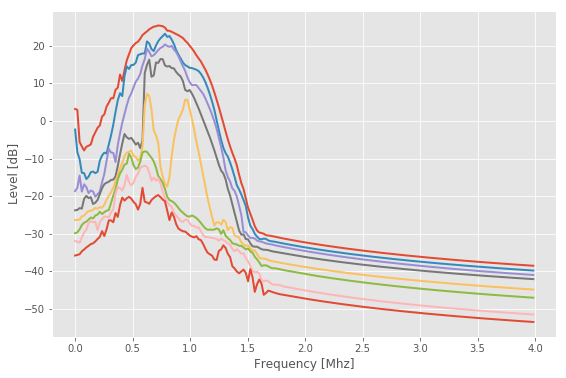

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
fig.subplots_adjust(left = 0.2, wspace = 0.4, hspace = 0.4)

for sous_id in range(nsous):
    axes.plot(freqs, dB_signal(sous_id, sig_y), 
              linewidth=2)

plt.xlabel("Frequency [Mhz]")
plt.ylabel("Level [dB]")
#axes.set_ylim([-80, 140])
#axes.grid()
#axes.set_ylabel("dB")
for _ in ['.pdf', '.png']:
    filename = 'Plots/2DTimeS8P'+str(por+1)+'Elastic'+ \
               str(ylim)+'_SV'+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# We load mat file of k values at different porosities
# data['por2'] array of size(n_freqs, n_modes, n_thickness)
Data_REF2D = sio.loadmat('Files_mat/k_REF2D_Datapy.mat')
# Define data of porosities, as the 4-D array
# [Por, Freq, k_val, width] --> shape [30,205,12,103]
DataPor = Data_REF2D['k_ref2D_Data']
Data_REF2D.keys()

dict_keys(['f', 'kmin', 'k_ref2D_Data', 'k', '__globals__', 'fmax', 'f2', '__version__', 'k2', '__header__', 'fmin', 'kmax'])

In [8]:
DataFreqs = np.reshape(Data_REF2D['f'], (205,))
lim = np.max(DataFreqs)

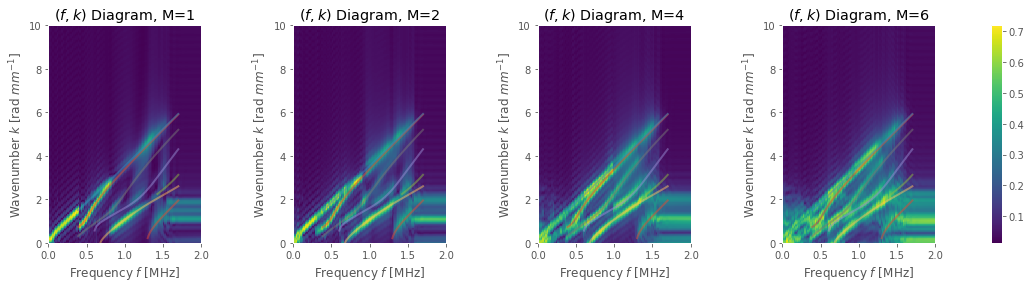

In [18]:
# Obtain index for data arrays
index_th = lambda x: int(round(x*10-8,2)//0.5)+int(round(ylim*10-8,2)%0.5)
th = index_th(ylim)
# Define first the theoretical k_max, where 0.4 denotes
# the distance between sensors
lim = 2*np.pi/(0.4)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22,4))
fig.subplots_adjust(left = 0.2, wspace = 0.6)
i = 0
for ax in axes.flat: 
    im = ax.imshow(matrix_fk_y[: , :, i].T, extent=[0, 4, 0, lim], 
                   aspect='auto')
    ax.plot(DataFreqs, DataPor[por, :, :, th], linewidth=2, alpha=0.5)
    ax.grid()
    ax.set_xlabel('Frequency $f$ [MHz]')
    ax.set_ylabel('Wavenumber $k$ [rad $mm^{-1}$]')
    ax.set_xlim([0., 2.])
    ax.set_ylim([0., 10])
    ax.set_title('$(f,k)$ Diagram, M='+str(M[i]))
    i += 1

fig.colorbar(im, ax=axes.ravel( ).tolist())
for _ in ['.pdf', '.png']:
    filename = 'Plots/2DTimeS8P'+str(por+1)+'ElasticFK'+ \
               str(ylim)+'M'+str(size)+'_y'+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Obtain index for data arrays
index_th = lambda x: int(round(x*10-8,2)//0.5)+int(round(ylim*10-8,2)%0.5)
th = index_th(ylim)
# Define first the theoretical k_max, where 0.4 denotes
# the distance between sensors
lim = 2*np.pi/(0.4)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22,4))
fig.subplots_adjust(left = 0.2, wspace = 0.6)
i = 0
for ax in axes.flat: 
    im = ax.imshow(matrix_fk_z[: , :, i].T, extent=[0, 4, 0, lim], 
                   aspect='auto')
    ax.plot(DataFreqs, DataPor[por, :, :, th], linewidth=2, alpha=0.5)
    ax.grid()
    ax.set_xlabel('Frequency $f$ [MHz]')
    ax.set_ylabel('Wavenumber $k$ [rad $mm^{-1}$]')
    ax.set_xlim([0., 2.])
    ax.set_ylim([0., 10])
    ax.set_title('Modes & MatriFK, M ='+str(M[i]))
    i += 1

fig.colorbar(im, ax=axes.ravel( ).tolist())
filename = 'Plots/2DTimeS8P'+str(por+1)+'ElasticFK'+ \
           str(ylim)+'M'+str(size)+'_z.png'
plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()